In [1]:
# Settings

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix

import lime
import lime.lime_tabular
from pdpbox import pdp, info_plots
from sklearn.tree import plot_tree
import shap

# do not display LGBM categorical override warning 
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# define path
my_path = "/Users/meikeepauline/Desktop/MA/"

# define variables
target_variable = ['DEFAULT_12M']
model_variables = ['fico','mi_pct','cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','channel','prop_type','loan_purpose','orig_loan_term','cd_ppty_val_type','us_reg','flag_fthb','cnt_borr','flag_mi','orig_loan_term_3grp','flag_orig_loan_term_HEQ_360M']
model_variables_ind = ['fico','mi_pct','cnt_units','cltv','dti','orig_upb','ltv','orig_loan_term','flag_fthb','cnt_borr','flag_mi','flag_orig_loan_term_HEQ_360M'\
                    ,'loan_purpose__C','loan_purpose__N','loan_purpose__P','channel__9','channel__B','channel__C','channel__R','channel__T','cd_ppty_val_type__1','cd_ppty_val_type__2','cd_ppty_val_type__3','cd_ppty_val_type__9','us_reg__Midwest','us_reg__Northeast','us_reg__Other','us_reg__South','us_reg__West','occpy_sts__I','occpy_sts__P']
all_variables = model_variables+target_variable

In [2]:
#Import dataset and print overview

df_csv = pd.read_csv(my_path+"DEV_SAMPLE5Y_FINAL.CSV", parse_dates=[3], dayfirst=True, dtype={'GROUP2': 'str', 'zipcode': 'str', 'cd_ppty_val_type': 'str', 'cd_zero_bal': 'str', 'flag_sc_raw': 'str', 'id_loan_preharp': 'str','ind_harp_raw': 'str', 'zero_bal_delq_sts': 'str'})

print(df_csv.head())          # print first 5 rows
print(df_csv.info())          # print information of data (null, type)

   Selected  DEFAULT_12M GROUP2      DATUM       id_loan  loan_age_noMod  \
0         1            0   2017 2017-12-01  F17Q40279565              63   
1         1            0   2017 2017-12-01  F17Q40215556              63   
2         1            0   2017 2017-12-01  F17Q40319954              34   
3         1            0   2017 2017-12-01  F17Q40189974              63   
4         1            0   2017 2017-12-01  F17Q40162839              63   

               KEEP_FLAG  fico  dt_first_pi flag_fthb_raw  ...  \
0  1;More than 12 months   681       201712             N  ...   
1  1;More than 12 months   716       201712             N  ...   
2  1;More than 12 months   778       201712             N  ...   
3  1;More than 12 months   797       201712             N  ...   
4  1;More than 12 months   717       201712             Y  ...   

   us_reg__Midwest  us_reg__Northeast  us_reg__Other  us_reg__South  \
0                0                  0              0              0   
1   

In [3]:
# Split data into Training and Test data set for model variables and target 

temp = df_csv[(df_csv.Selected == 1)]
X_train = temp[model_variables_ind]
y_train = temp[target_variable]

temp = df_csv[(df_csv.Selected == 0)]
X_test = temp[model_variables_ind]
y_test = temp[target_variable]

inp_data = df_csv[model_variables_ind]
out_data = df_csv[target_variable]

df = df_csv[target_variable+model_variables_ind]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print("DR of training sample: ", X_train["DEFAULT_12M"].mean())
#print("DR of test sample: ", X_test["DEFAULT_12M"].mean())

(7650336, 31) (3278709, 31) (7650336, 1) (3278709, 1)


In [4]:
# Convert the data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [5]:
# Set parameters for LightGBM
params = {
    'boosting_type': 'rf',  # Random Forest
    'objective': 'binary',  # Binary classification problem
    'metric': 'binary_error',  # Metric to evaluate performance
    'num_leaves': 31,  # Maximum number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9,  # Fraction of features to be used in each boosting round
    'bagging_fraction': 0.8,  # Fraction of data to be used in each boosting round
    'bagging_freq': 5,  # Frequency for bagging
    'num_threads': 4  # Number of threads for LightGBM to use
}

In [6]:
# Train the model
num_round = 100  # Number of boosting rounds
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=10)

[LightGBM] [Info] Number of positive: 73467, number of negative: 7576869
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.622191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 7650336, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009603 -> initscore=-4.636019
[LightGBM] [Info] Start training from score -4.636019
[1]	valid_0's binary_error: 0.0118412
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0118412
[3]	valid_0's binary_error: 0.0118412
[4]	valid_0's binary_error: 0.00998076
[5]	valid_0's binary_error: 0.00998076
[6]	valid_0's binary_error: 0.00998076
[7]	valid_0's binary_error: 0.00996154
[8]	valid_0's binary_error: 0.00996154
[9]	valid_0's binary_error: 0.00993013
[10]	valid_0's binary_error

In [7]:
# Make predictions on the test set
y_pred = pd.DataFrame(bst.predict(X_test, num_iteration=bst.best_iteration))

In [8]:
for threshold in np.arange(0.0, 0.1, 0.005): 
    y_pred_f1 = np.where(y_pred > threshold, 1, 0)
    f1 = f1_score(y_test, y_pred_f1)
    print('Threshold:', threshold, 'F1-score:', f1)

Threshold: 0.0 F1-score: 0.019021258894124236
Threshold: 0.005 F1-score: 0.02242723332257376
Threshold: 0.01 F1-score: 0.035669648142424334
Threshold: 0.015 F1-score: 0.04386830734136123
Threshold: 0.02 F1-score: 0.049672304808912375
Threshold: 0.025 F1-score: 0.05395387365849311
Threshold: 0.03 F1-score: 0.055167203125383917
Threshold: 0.035 F1-score: 0.05710834034559694
Threshold: 0.04 F1-score: 0.05846334507632947
Threshold: 0.045 F1-score: 0.059481907938132905
Threshold: 0.05 F1-score: 0.059935907810830934
Threshold: 0.055 F1-score: 0.06001560617883469
Threshold: 0.06 F1-score: 0.05966787654085707
Threshold: 0.065 F1-score: 0.05836200426896425
Threshold: 0.07 F1-score: 0.05686778188501138
Threshold: 0.075 F1-score: 0.05585942306186593
Threshold: 0.08 F1-score: 0.054897140339077395
Threshold: 0.085 F1-score: 0.05421928242132692
Threshold: 0.09 F1-score: 0.05313493511231562
Threshold: 0.095 F1-score: 0.052602111549536104


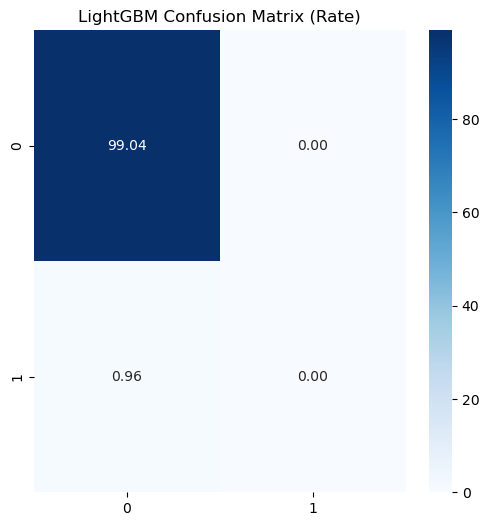

In [9]:
y_pred.rename(columns={y_pred.columns[0]: "PD_PRED" }, inplace = True)
y_pred['DEFAULT_12M_PRED'] = np.where(y_pred["PD_PRED"] >= 0.55, 1, 0)

plt.figure(figsize=(6,6))
cf_matrix = confusion_matrix(y_test, y_pred["DEFAULT_12M_PRED"])
sns.heatmap((cf_matrix / np.sum(cf_matrix)*100), annot = True, fmt=".2f", cmap="Blues")
plt.title("LightGBM Confusion Matrix (Rate)")
plt.show()

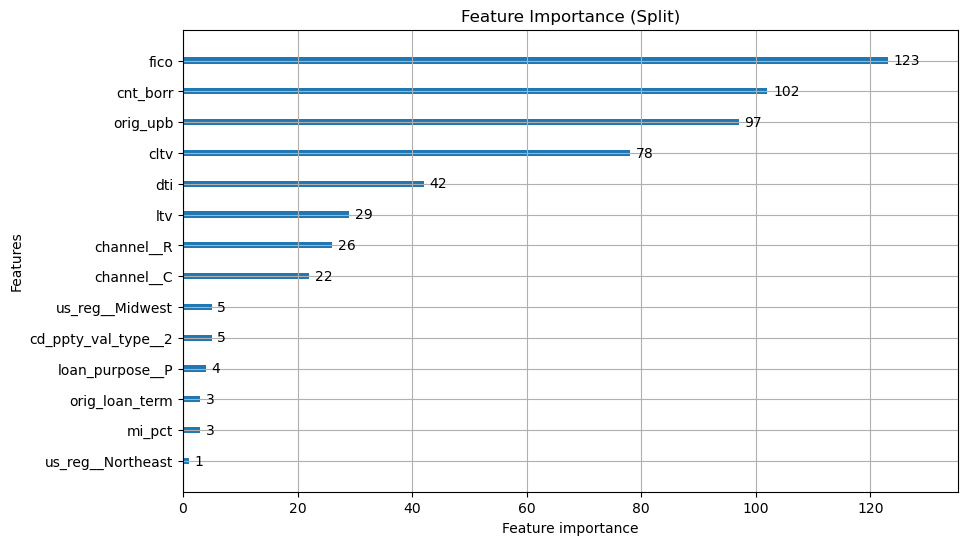

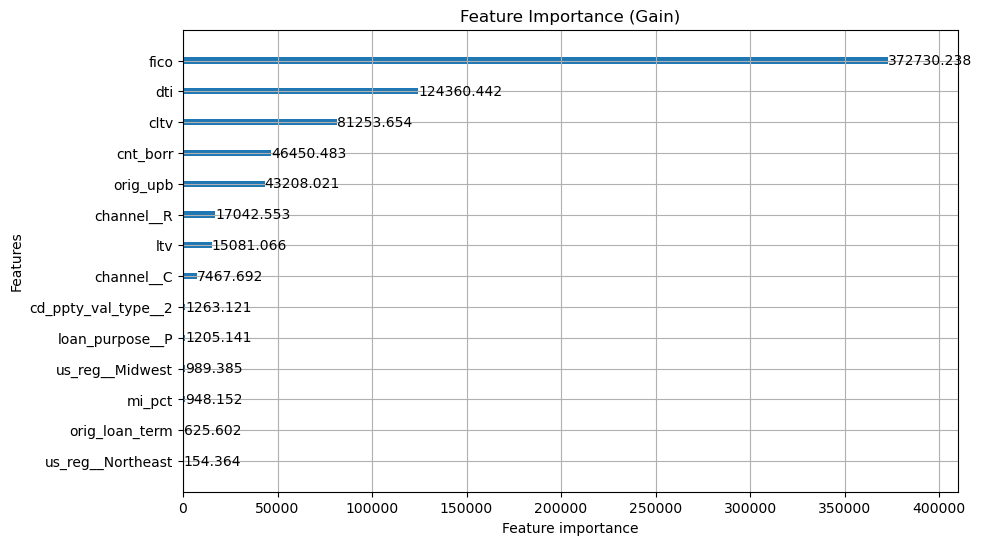

In [10]:
# Feature Importance Analysis
lgb.plot_importance(bst, importance_type='split', figsize=(10, 6), title='Feature Importance (Split)')
plt.show()

lgb.plot_importance(bst, importance_type='gain', figsize=(10, 6), title='Feature Importance (Gain)')
plt.show()

In [11]:
# this is required as LIME requires class probabilities in case of classification example
# LightGBM directly returns probability for class 1 by default 

def prob(data):
    return np.array(list(zip(1-bst.predict(data),bst.predict(data))))

# LIME (Local Interpretable Model-agnostic Explanations)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], discretize_continuous=True)

# Choose a random instance for explanation
instance_idx = 0
instance = X_test.iloc[[instance_idx]].values[0]
exp = explainer.explain_instance(instance, prob, num_features=len(X_test.columns))

exp.show_in_notebook(show_all=False)

<Figure size 2000x1000 with 0 Axes>

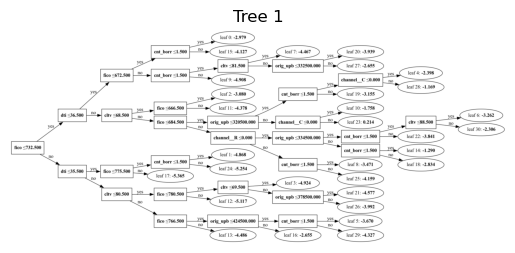

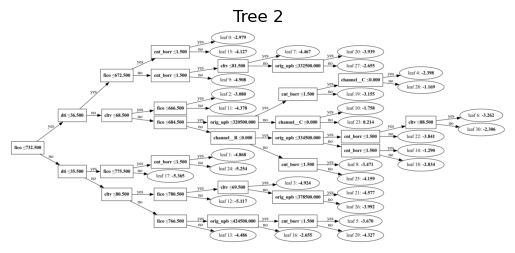

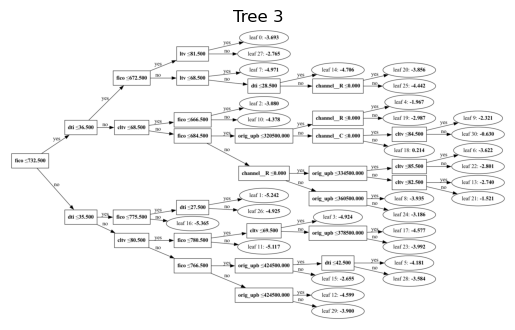

In [22]:
# Visualize a few decision trees in the random forest
plt.figure(figsize=(20, 10))
for i in range(3):  # Display the first 3 trees
    lgb.plot_tree(bst, tree_index=i)
    plt.title(f'Tree {i+1}')
plt.show()

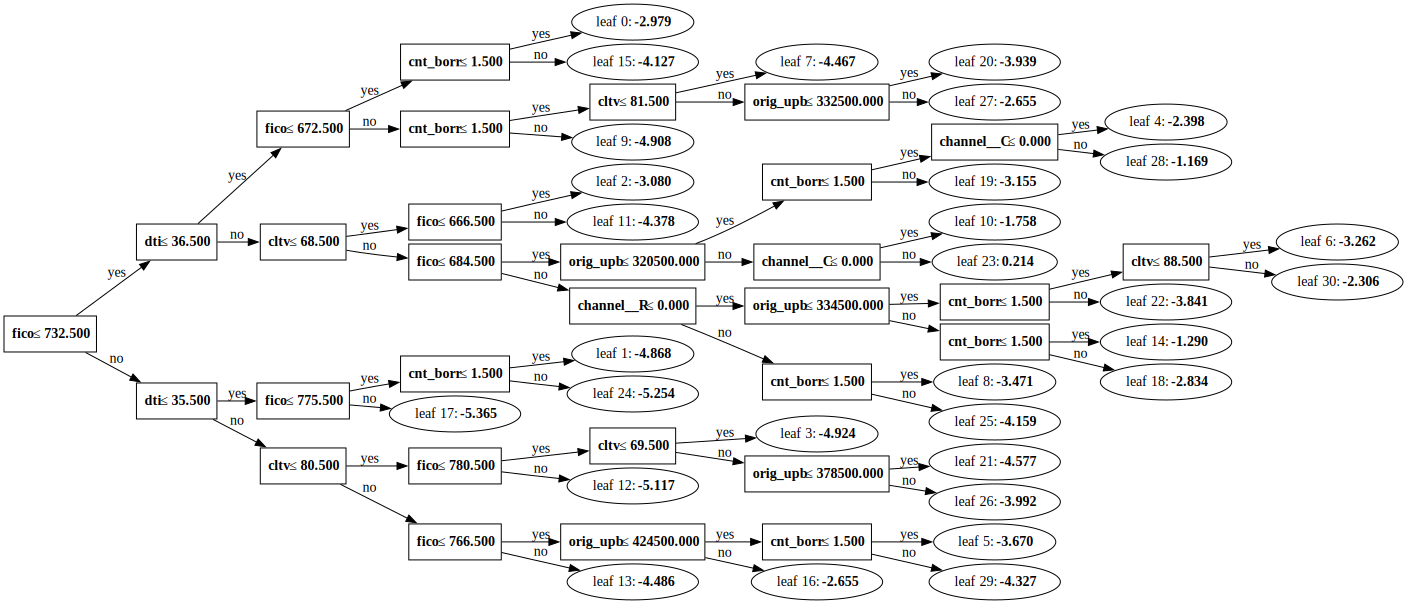

<Figure size 2000x1000 with 0 Axes>

In [23]:
plt.figure(figsize=(20, 10))
graph = lgb.create_tree_digraph(bst)
graph

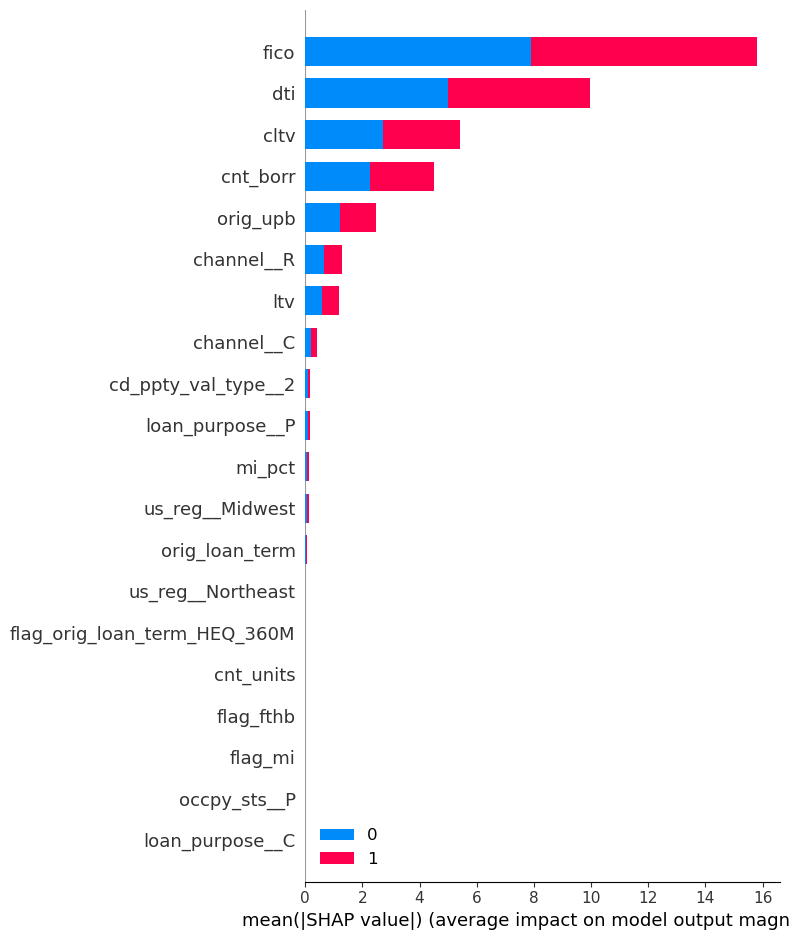

In [24]:
# SHAP (SHapley Additive exPlanations)
explainer_shap = shap.TreeExplainer(bst)
shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=['0', '1'])
plt.show()

In [27]:
from sklearn.model_selection import (train_test_split, GridSearchCV)

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['rf'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(bst, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'train'